In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-images-idx3-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-labels-idx1-ubyte


# Load csv file

In [2]:
train_csv_path = '/kaggle/input/fashionmnist/fashion-mnist_train.csv'
test_csv_path = '/kaggle/input/fashionmnist/fashion-mnist_test.csv'

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# remove first column and convert to numpy array, transform to [0..1]
x_train = train_df.drop(columns=['label']).values / 255
y_train = train_df['label'].values
x_test = test_df.drop(columns=['label']).values / 255
y_test = test_df['label'].values

# Show a sample image

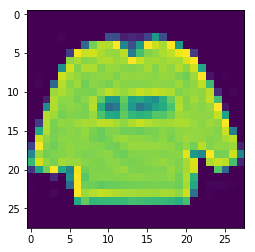

In [3]:
import matplotlib.pyplot as plt

sample_image = x_train[0,:].reshape((28,28))
plt.imshow(sample_image)


# CNN model

In [4]:
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [5]:
image_rows = 28
image_cols = 28
batch_size = 32
image_shape = (image_rows, image_cols, 1)

In [6]:
x_train = x_train.reshape(x_train.shape[0], *image_shape)
x_test = x_test.reshape(x_test.shape[0], *image_shape)

In [7]:
def create_model():
    inputs = Input(shape=(28,28,1))
    
    # Gated 1
    gated_x = Conv2D(filters=32, kernel_size=3, activation='sigmoid')(inputs)
    x = Conv2D(filters=32, kernel_size=3, activation='tanh')(inputs)
    x = keras.layers.multiply([x,gated_x])
    x = MaxPooling2D((2,2))(x)
    
    # Gated 2
    gated_x = Conv2D(filters=64, kernel_size=3, activation='sigmoid', padding='same')(x)
    x = Conv2D(filters=64, kernel_size=3, activation='tanh', padding='same')(x)
    x = keras.layers.multiply([x,gated_x])
    x = MaxPooling2D((2,2))(x)
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=x)
    
    return model

In [8]:
model = create_model()

In [9]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [10]:
max_epochs = 50

history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=max_epochs,
    verbose=1,
)

Epoch 1/50
60000/60000 [==============================] - 10s 171us/step - loss: 0.4508 - accuracy: 0.8355
Epoch 2/50
60000/60000 [==============================] - 7s 122us/step - loss: 0.3139 - accuracy: 0.8859
Epoch 3/50
60000/60000 [==============================] - 7s 113us/step - loss: 0.2789 - accuracy: 0.8982
Epoch 4/50
60000/60000 [==============================] - 7s 113us/step - loss: 0.2600 - accuracy: 0.9053
Epoch 5/50
60000/60000 [==============================] - 7s 113us/step - loss: 0.2461 - accuracy: 0.9105
Epoch 6/50
60000/60000 [==============================] - 7s 113us/step - loss: 0.2327 - accuracy: 0.9162
Epoch 7/50
60000/60000 [==============================] - 7s 112us/step - loss: 0.2235 - accuracy: 0.9189
Epoch 8/50
60000/60000 [==============================] - 7s 113us/step - loss: 0.2167 - accuracy: 0.9215
Epoch 9/50
60000/60000 [==============================] - 7s 113us/step - loss: 0.2105 - accuracy: 0.9220
Epoch 10/50
60000/60000 [====================

In [11]:
scores = model.evaluate(x_test, y_test, verbose=1)
scores

10000/10000 [==============================] - 1s 70us/step


[0.24376283545829355, 0.9284999966621399]

# show miss classified images


In [12]:
predicts = model.predict(x_test)
y_hat = np.argmax(predicts, axis=1)
y_hat

array([0, 1, 2, ..., 8, 8, 1])

In [13]:
mis_classified_idx = y_test != y_hat
print("Total miss: {}".format(len(mis_classified_idx[mis_classified_idx])))

Total miss: 715


In [14]:
labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

Predicted = Sneaker, Groundtruth = Bag


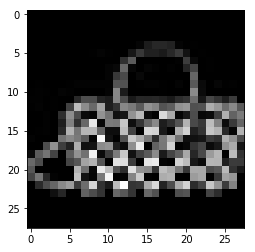

In [15]:
index = 10
image = x_test[mis_classified_idx][index]
image = np.squeeze(image)
plt.imshow(image, cmap='gray')
print('Predicted = {}, Groundtruth = {}'.format(labels[y_hat[mis_classified_idx][index]], labels[y_test[mis_classified_idx][index]]))

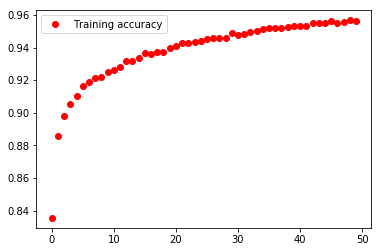

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
acc = history.history['accuracy']
epoches = range(len(acc))

plt.plot(epoches, acc, 'ro', label='Training accuracy')
plt.legend()
plt.show()